## Problem Statement:
Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings as war
war.filterwarnings('ignore')

import re

In [2]:
df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv')
df.head()   

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


#### Data Dictionary:

- ‘Unnamed 0’- Index of the dataset
- Email_hash- Anonymised Personal Identifiable Information (PII)
- Company_hash- Current employer of the learner
- orgyear- Employment start date
- CTC- Current CTC
- Job_position- Job profile in the company
- CTC_updated_year: Year in which CTC got updated (Yearly increments, Promotions)

## Exploration and Pre-processing

In [3]:
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


#### Missing Values

In [5]:
df.isnull().sum()

Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52562
ctc_updated_year        0
dtype: int64

- There are lot of null values in Job position,org year and company column

#### Job Position

In [6]:
df['job_position'].value_counts()

Backend Engineer                      43554
FullStack Engineer                    24717
Other                                 18071
Frontend Engineer                     10417
Engineering Leadership                 6870
                                      ...  
Matlab programmer                         1
Solution Integration Consultant I         1
Advisory Consultant - UI/UX Expert        1
Storw                                     1
Software Engineer Android Intern          1
Name: job_position, Length: 1017, dtype: int64

In [7]:
df['job_position'].nunique()

1017

In [8]:
df_job_count = df['job_position'].value_counts().reset_index()
df_job_count.rename(columns={'index':'position', 'job_position':'count'},inplace=True)

In [9]:
df_job_count[df_job_count['count'] == 1]

,position,count
247,Research Engineer 2,1
248,Senior Sofware Engineer,1
249,System admin,1
250,Mainframe Developer,1
251,Security analyst,1
...,...,...
1012,Matlab programmer,1
1013,Solution Integration Consultant I,1
1014,Advisory Consultant - UI/UX Expert,1
1015,Storw,1


In [10]:
#Some of the popular Job Title
df_job_count[df_job_count['count'] > 100]

,position,count
0,Backend Engineer,43554
1,FullStack Engineer,24717
2,Other,18071
3,Frontend Engineer,10417
4,Engineering Leadership,6870
5,QA Engineer,6587
6,Data Scientist,5368
7,Android Engineer,5357
8,SDET,4967
9,Devops Engineer,4612


Below are some of the apparaches to impute the null values for Job Position feature. 

1. Since 'Other' is a popular job title and we have to impute some values for our missing values, might as well go with other. 
2. The other apporach will be based on completely treat these values as a separate category. 
3. Use KNN Imputer (To use KNN Imputer for categorical values we need to encode these values to numerical first. In this case target encoding should work)

In [11]:
df[df['job_position'] == 'Other']['ctc'].describe()

count    1.807100e+04
mean     3.973584e+06
std      2.087977e+07
min      2.400000e+01
25%      4.000000e+05
50%      6.600000e+05
75%      1.210000e+06
max      2.000000e+08
Name: ctc, dtype: float64

In [12]:
df[df['job_position'].isnull()]['ctc'].describe()

count    5.256200e+04
mean     1.993828e+06
std      1.157060e+07
min      6.000000e+00
25%      5.000000e+05
50%      8.199990e+05
75%      1.500000e+06
max      1.000150e+09
Name: ctc, dtype: float64

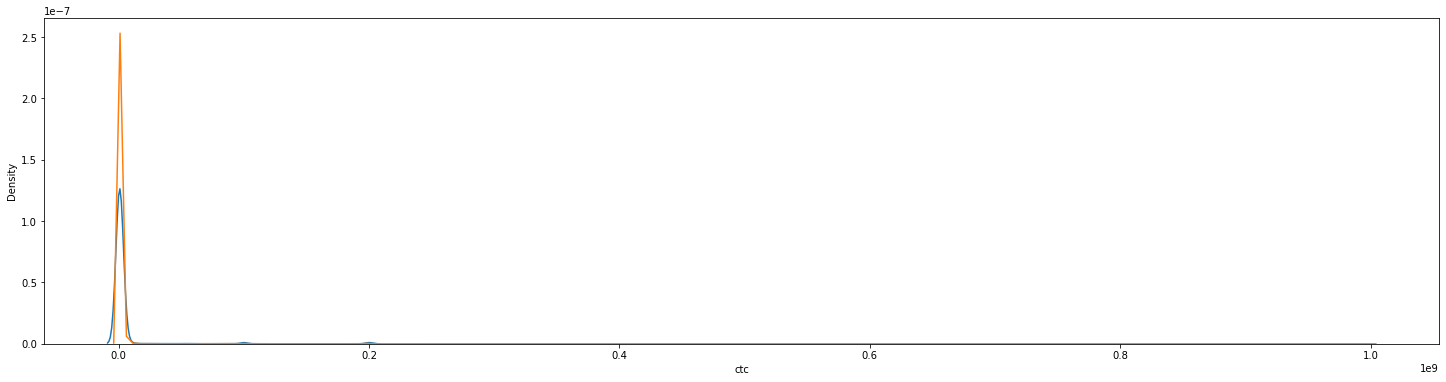

In [13]:
plt.figure(figsize=(25,6))
sns.distplot(df[df['job_position'] == 'Other']['ctc'],hist=False)
sns.distplot(df[df['job_position'].isnull()]['ctc'], hist= False)
plt.show()


In [14]:
df[df['job_position'] == 'Other']['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto        1058
xzegojo                           866
eqtoytq                           618
wgszxkvzn                         499
fxuqg rxbxnta                     420
                                 ... 
hqmvz tootznxvr xzaxv ucn rna       1
xu xzehoxgz                         1
hzxctqovr egqwto xzahonqxto         1
xzahwnho wgzohrnvzno ucn rna        1
atdntqgho xzw                       1
Name: company_hash, Length: 6083, dtype: int64

In [15]:
df[df['job_position'].isnull()]['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto            3028
xzegojo                              1937
zgn vuurxwvmrt vwwghzn               1380
wgszxkvzn                            1138
zgn vuurxwvmrt                       1064
                                     ... 
nyt bgovxw wgbuvzj                      1
mxsontu ntwyzgrgsxto ucn rna            1
qtogzvzwt tahctznhqto                   1
utgwxn ogenfvqt ogrhnxgzo ucn rna       1
atdntqgho xzw                           1
Name: company_hash, Length: 12310, dtype: int64

In [16]:
df[(df['company_hash'] == 'nvnv wgzohrnvzwj otqcxwto') & df['job_position'].isin(['Other',np.NaN])]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
337,337,nvnv wgzohrnvzwj otqcxwto,b44191ed851a1dff51ae2cf2a393fc6799d045de7c0b01...,2018.0,440000,Other,2021.0
457,457,nvnv wgzohrnvzwj otqcxwto,717718247f219883fbb9158d11274e033130973fa40dbe...,2015.0,870000,Other,2020.0
507,507,nvnv wgzohrnvzwj otqcxwto,bca52d2d543819b12a99e977b790449277dfe8aebb487f...,2020.0,670000,NaN,2020.0
572,572,nvnv wgzohrnvzwj otqcxwto,6cf36267e3c4454dd4fd6ac7da284863529d721eee847f...,2019.0,300000,NaN,2021.0
634,634,nvnv wgzohrnvzwj otqcxwto,8d9a9bd7f4e3b5b3010ffb2afc1f19ceb39f8324214657...,2015.0,600000,Other,2020.0
...,...,...,...,...,...,...,...
205526,206606,nvnv wgzohrnvzwj otqcxwto,f4d553425ea2e09ec720a4527a51fda7dfdb56c0edee95...,2012.0,580000,NaN,2016.0
205609,206689,nvnv wgzohrnvzwj otqcxwto,c045760766c2b3025998099c8d86422c1a7dba37e3459e...,2020.0,330000,NaN,2020.0
205755,206835,nvnv wgzohrnvzwj otqcxwto,b4e3ab7d11b8b107b3048ada94e2ff18e10755691be6c8...,2019.0,740000,NaN,2021.0
205781,206861,nvnv wgzohrnvzwj otqcxwto,9c7572369588ff6c58339ef315b446a039a44ac9a15cbf...,2019.0,672000,NaN,2019.0


In [17]:
# Imputing all Null values as 'None' which is a separate category as 

df['job_position'].fillna('None',inplace=True)

Removing any special characters from 

In [18]:
def job_label(x):
    """ Function to return the clean data"""
    return re.sub('[^A-Za-z0-9 ]+', '', x)

In [19]:
df['job_position'].fillna('None',inplace=True)

In [20]:
df.isnull().sum()

Unnamed: 0           0
company_hash        44
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

#### Company Level Exploration

In [21]:
df['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto     8337
xzegojo                       5381
vbvkgz                        3481
zgn vuurxwvmrt vwwghzn        3411
wgszxkvzn                     3240
                              ... 
rtmgzwgxz                        1
tktneo ogrhnxgzo ucn rna         1
fgftdu ntwyzgrgsxto              1
stbxzx wgzohrnxzs otqcxwto       1
rggu rxon                        1
Name: company_hash, Length: 37299, dtype: int64

In [22]:
df.isnull().sum()

Unnamed: 0           0
company_hash        44
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

In [23]:
df[df['company_hash'].isnull()]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
1115,1115,NaN,8fe09b732fe2e5b66c14904fd02ff89fb54f458465ac1e...,2022.0,66600000,None,2020.0
2400,2400,NaN,1074b55f02e6fc88596db85854e057c98cb53c038e0d7f...,2018.0,250000,Other,2019.0
3277,3277,NaN,66263f4942b046c67ae6e2570e7825c03792631a0b13f1...,2018.0,500000,Other,2019.0
4205,4205,NaN,6eb55d779699a2ea94f340ab7a58c8ec505e38bbb41214...,2018.0,600000,None,2020.0
4596,4597,NaN,18813fe2a50a45cc02c5b3871c676bd147c80ff0327ee9...,2020.0,300000,None,2021.0
11753,11761,NaN,ea4f735b9357e8086a42bacc1f64b18e98c3dd1ad81f60...,2018.0,300000,None,2021.0
14739,14748,NaN,b4a56d1199bc569aabd30cba8ea7a86fbddc85211453ba...,2013.0,1600000,None,2021.0
18853,18865,NaN,07a60d6e853852471b0963b78a0a3074532572a2580864...,2017.0,700000,FullStack Engineer,2021.0
19466,19478,NaN,07a60d6e853852471b0963b78a0a3074532572a2580864...,2017.0,700000,None,2021.0
22846,22864,NaN,bdce6736cc1d55a909a46aed9e0bfdcd7cd523bfcf9b63...,2010.0,2000000,None,2020.0


In [24]:
df['company_hash'].fillna('Others',inplace=True)

In [25]:
df['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto            8337
xzegojo                              5381
vbvkgz                               3481
zgn vuurxwvmrt vwwghzn               3411
wgszxkvzn                            3240
                                     ... 
yghb ntwyzgrgsj                         1
lhbupxzs xzntqzvnxgzvr rru              1
mxsnvuu vzvrjnxwo uqxcvnt rxbxnta       1
vkhsv ntrtbvnxwo ucn rna                1
rggu rxon                               1
Name: company_hash, Length: 37300, dtype: int64

In [26]:
df.isnull().sum()

Unnamed: 0           0
company_hash         0
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

##### Organizational Year

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205843 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      205843 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [28]:
df['orgyear'].value_counts()

2018.0    25256
2019.0    23427
2017.0    23239
2016.0    23043
2015.0    20610
          ...  
1981.0        1
1972.0        1
208.0         1
4.0           1
1900.0        1
Name: orgyear, Length: 77, dtype: int64

In [29]:
# df['orgyear'].fillna(2018.0,inplace=True)
# df['orgyear'] = df['orgyear'].astype('int64')

In [30]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['orgyear'].value_counts()

These rows doesn't seem to right. We need to check further before dropping them

In [31]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['company_hash'].value_counts()

In [32]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['job_position'].value_counts()

In [33]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['ctc_updated_year'].value_counts()

In [34]:
df.isnull().sum()

Unnamed: 0           0
company_hash         0
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

In [35]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
df['orgyear'] = imputer.fit_transform(np.array(df['orgyear']).reshape(-1,1))

In [36]:
df.isnull().sum()

Unnamed: 0          0
company_hash        0
email_hash          0
orgyear             0
ctc                 0
job_position        0
ctc_updated_year    0
dtype: int64

In [37]:
df['orgyear'] = df['orgyear'].astype('int')
df['orgyear'].value_counts()

2018    25256
2019    23427
2017    23239
2016    23043
2015    20610
        ...  
1981        1
200         1
201         1
208         1
206         1
Name: orgyear, Length: 77, dtype: int64

All null values are sorted. Let perform a certain level of exploration

### Exploration

In [38]:
df['ctc_updated_year'] = df['ctc_updated_year'].astype('int64')

In [39]:
df['YOE'] = df['ctc_updated_year'] - df['orgyear']

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        205843 non-null  int64 
 1   company_hash      205843 non-null  object
 2   email_hash        205843 non-null  object
 3   orgyear           205843 non-null  int32 
 4   ctc               205843 non-null  int64 
 5   job_position      205843 non-null  object
 6   ctc_updated_year  205843 non-null  int64 
 7   YOE               205843 non-null  int64 
dtypes: int32(1), int64(4), object(3)
memory usage: 11.8+ MB


In [41]:
#Filtering out rows where YOE is negative i.e. Employee got CTC update  before joining the Organization
df = df[~(df['YOE'] < 0)]

In [42]:
# Dropping the Unamed Column. 

df.drop(columns='Unnamed: 0', axis=1,inplace=True)

In [43]:
# Five Point summary of the CTC
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df['ctc'].describe()

count       196996.000
mean       2211286.261
std       11423829.554
min              2.000
25%         530000.000
50%         950000.000
75%        1700000.000
max     1000150000.000
Name: ctc, dtype: float64

In [44]:
# Max CTC
df[df['ctc'] == 1000150000]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE
72824,whmxw rgsxwo uqxcvnt rxbxnta,29a71dd13adf6d2d497571a565bb3096cf66cb46cd1ece...,2015,1000150000,None,2020,5


In [45]:
# Max CTC
df[df['ctc'] == 2]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE
135435,xzntqcxtfmxn,3505b02549ebe2c95840ac6f0a35561a3b4cbe4b79cdb1...,2014,2,Backend Engineer,2019,5


There are outliers ofcourse...

In [46]:
df_company_YOE_agg = df[['company_hash','YOE','ctc']].groupby(by=['company_hash','YOE']).mean().reset_index()
df_company_YOE_agg.rename(columns={'ctc':'mean_ctc_by_company_YOE'},inplace=True)
df_company_YOE_agg

,company_hash,YOE,mean_ctc_by_company_YOE
0,0,0,100000.000
1,0000,3,300000.000
2,01 ojztqsj,3,270000.000
3,01 ojztqsj,8,830000.000
4,05mz exzytvrny uqxcvnt rxbxnta,2,1100000.000
...,...,...,...
64395,zz,7,1370000.000
64396,zz,12,500000.000
64397,zzb ztdnstz vacxogqj ucn rna,4,600000.000
64398,zzgato,3,130000.000


In [47]:
df_company_YOE_agg[df_company_YOE_agg['company_hash'] == 'xmb']

,company_hash,YOE,mean_ctc_by_company_YOE
56154,xmb,0,1203888.870
56155,xmb,1,836117.117
56156,xmb,2,787762.463
56157,xmb,3,2240246.189
56158,xmb,4,1905879.990
56159,xmb,5,1059696.949
56160,xmb,6,1198286.724
56161,xmb,7,1071701.092
56162,xmb,8,1307608.652
56163,xmb,9,1793541.667


In [48]:
df[(df['company_hash'] == 'xmb') & (df['YOE'] == 10)]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE
14145,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,None,2021,10
20525,xmb,0c089525f3291d982e0b0ac6d10cdd51db673b507052b2...,2011,1700000,None,2021,10
26914,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,Backend Engineer,2021,10
26992,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,Senior Staff Software Engineer,2021,10
31762,xmb,636eb20896ae85cfdb238b27ce18953eaa3cabc81d25f0...,2011,1700000,None,2021,10
34871,xmb,7eed1e6f4baf48dd7d3fdcb3d3399d662a0a5c51478521...,2011,1100000,None,2021,10
35696,xmb,7eed1e6f4baf48dd7d3fdcb3d3399d662a0a5c51478521...,2011,1100000,Data Scientist,2021,10
39608,xmb,8ecfdffaadcd3dfcf3e5a8022cf123e22c3938c46c3559...,2009,1200000,Backend Engineer,2019,10
48844,xmb,fe6b44fc8d4ed82cf6cb6903f1583bd2e62641e5996cad...,2011,1600000,Backend Architect,2021,10
61004,xmb,0c089525f3291d982e0b0ac6d10cdd51db673b507052b2...,2011,1700000,FullStack Engineer,2021,10


In [49]:
df = pd.merge(df,df_company_YOE_agg, how = 'outer', on =['company_hash','YOE'])
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,4,942500.000
1,atrgxnnt xzaxv,b4dcd1e7ac426014a32ae303e4b527325d482e4d2c4bef...,2014,1000000,Backend Engineer,2018,4,942500.000
2,atrgxnnt xzaxv,0d2f25432591093f5907a8681d600f869bbe7c2ae39cd7...,2017,600000,Android Engineer,2021,4,942500.000
3,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014,1070000,Other,2018,4,942500.000
4,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,1,2869833.292


In [50]:
df[(df['company_hash'] == 'xmb') & (df['YOE'] == 10)]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE
94882,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,None,2021,10,1518260.870
94883,xmb,0c089525f3291d982e0b0ac6d10cdd51db673b507052b2...,2011,1700000,None,2021,10,1518260.870
94884,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,Backend Engineer,2021,10,1518260.870
94885,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,Senior Staff Software Engineer,2021,10,1518260.870
94886,xmb,636eb20896ae85cfdb238b27ce18953eaa3cabc81d25f0...,2011,1700000,None,2021,10,1518260.870
94887,xmb,7eed1e6f4baf48dd7d3fdcb3d3399d662a0a5c51478521...,2011,1100000,None,2021,10,1518260.870
94888,xmb,7eed1e6f4baf48dd7d3fdcb3d3399d662a0a5c51478521...,2011,1100000,Data Scientist,2021,10,1518260.870
94889,xmb,8ecfdffaadcd3dfcf3e5a8022cf123e22c3938c46c3559...,2009,1200000,Backend Engineer,2019,10,1518260.870
94890,xmb,fe6b44fc8d4ed82cf6cb6903f1583bd2e62641e5996cad...,2011,1600000,Backend Architect,2021,10,1518260.870
94891,xmb,0c089525f3291d982e0b0ac6d10cdd51db673b507052b2...,2011,1700000,FullStack Engineer,2021,10,1518260.870


In [51]:
def label_by_company_yoe(df):
    if df['ctc'] > df['mean_ctc_by_company_YOE']:
        return 1
    elif ((df['ctc'] > (df['mean_ctc_by_company_YOE'] * 0.50)) and (df['ctc'] < df['mean_ctc_by_company_YOE'])):
        return 2
    else:
        return 3
        

In [52]:
df['label_by_company_yoe'] = df.apply(label_by_company_yoe, axis=1)

In [53]:
df[(df['company_hash'] == 'xmb') & (df['YOE'] == 10)]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe
94882,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,None,2021,10,1518260.870,1
94883,xmb,0c089525f3291d982e0b0ac6d10cdd51db673b507052b2...,2011,1700000,None,2021,10,1518260.870,1
94884,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,Backend Engineer,2021,10,1518260.870,1
94885,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,Senior Staff Software Engineer,2021,10,1518260.870,1
94886,xmb,636eb20896ae85cfdb238b27ce18953eaa3cabc81d25f0...,2011,1700000,None,2021,10,1518260.870,1
94887,xmb,7eed1e6f4baf48dd7d3fdcb3d3399d662a0a5c51478521...,2011,1100000,None,2021,10,1518260.870,2
94888,xmb,7eed1e6f4baf48dd7d3fdcb3d3399d662a0a5c51478521...,2011,1100000,Data Scientist,2021,10,1518260.870,2
94889,xmb,8ecfdffaadcd3dfcf3e5a8022cf123e22c3938c46c3559...,2009,1200000,Backend Engineer,2019,10,1518260.870,2
94890,xmb,fe6b44fc8d4ed82cf6cb6903f1583bd2e62641e5996cad...,2011,1600000,Backend Architect,2021,10,1518260.870,1
94891,xmb,0c089525f3291d982e0b0ac6d10cdd51db673b507052b2...,2011,1700000,FullStack Engineer,2021,10,1518260.870,1


In [54]:
df['label_by_company_yoe'].value_counts()

3    97872
2    53495
1    45629
Name: label_by_company_yoe, dtype: int64

In [55]:
df_company_job_agg = df[['company_hash','job_position','ctc']].groupby(by=['company_hash','job_position']).mean().reset_index()
df_company_job_agg.rename(columns={'ctc':'mean_ctc_by_company_job'},inplace=True)
df_company_job_agg

,company_hash,job_position,mean_ctc_by_company_job
0,0,None,100000.000
1,0,Other,100000.000
2,0000,Other,300000.000
3,01 ojztqsj,Android Engineer,270000.000
4,01 ojztqsj,Frontend Engineer,830000.000
...,...,...,...
69510,zz,Other,1370000.000
69511,zzb ztdnstz vacxogqj ucn rna,FullStack Engineer,600000.000
69512,zzb ztdnstz vacxogqj ucn rna,None,600000.000
69513,zzgato,None,130000.000


In [56]:
df = pd.merge(df,df_company_job_agg, how = 'outer', on =['company_hash','job_position'])
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,4,942500.000,1,1085000.000
1,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014,1070000,Other,2018,4,942500.000,1,1085000.000
2,atrgxnnt xzaxv,b4dcd1e7ac426014a32ae303e4b527325d482e4d2c4bef...,2014,1000000,Backend Engineer,2018,4,942500.000,1,750000.000
3,atrgxnnt xzaxv,a309a8c6610af7e9f0a88cfb67f9a0095b0dde63475475...,2019,500000,Backend Engineer,2020,1,500000.000,3,750000.000
4,atrgxnnt xzaxv,0d2f25432591093f5907a8681d600f869bbe7c2ae39cd7...,2017,600000,Android Engineer,2021,4,942500.000,2,600000.000


In [57]:
def label_by_company_job(df):
    if df['ctc'] > df['mean_ctc_by_company_job']:
        return 1
    elif ((df['ctc'] > (df['mean_ctc_by_company_job'] * 0.50)) and (df['ctc'] < df['mean_ctc_by_company_job'])):
        return 2
    else:
        return 3
        

In [58]:
df['label_by_company_job'] = df.apply(label_by_company_job,axis=1)

In [59]:
df[(df['company_hash'] == 'xmb') & (df['YOE'] == 10)]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job
75294,xmb,7f8f36b1a0fe2c4dcf4dc95580e7ed3b9bf573cf4d0ae7...,2009,2500000,Engineering Leadership,2019,10,1518260.870,1,2885535.714,2
75343,xmb,9550c0c9341dbae5da8ecee4c1d573cb1c0f8742cdb8f6...,2011,1800000,Support Engineer,2021,10,1518260.870,1,596636.273,1
75473,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,Backend Engineer,2021,10,1518260.870,1,1314099.993,1
75474,xmb,8ecfdffaadcd3dfcf3e5a8022cf123e22c3938c46c3559...,2009,1200000,Backend Engineer,2019,10,1518260.870,2,1314099.993,2
75799,xmb,09fe72274cdac08c225e518014adaac4c1b0fbc04afb6b...,2011,1700000,None,2021,10,1518260.870,1,1389351.126,1
75800,xmb,0c089525f3291d982e0b0ac6d10cdd51db673b507052b2...,2011,1700000,None,2021,10,1518260.870,1,1389351.126,1
75801,xmb,636eb20896ae85cfdb238b27ce18953eaa3cabc81d25f0...,2011,1700000,None,2021,10,1518260.870,1,1389351.126,1
75802,xmb,7eed1e6f4baf48dd7d3fdcb3d3399d662a0a5c51478521...,2011,1100000,None,2021,10,1518260.870,2,1389351.126,2
75803,xmb,a3f498b2be2f9466ba89f68f5a2327174c17f1091fa86f...,2011,2400000,None,2021,10,1518260.870,1,1389351.126,1
75804,xmb,46b3ec449d46c7ab43b7d8f6e809bb07837b1e6d1e0920...,2011,1000000,None,2021,10,1518260.870,2,1389351.126,2


In [60]:
df_company_agg = df[['company_hash','ctc']].groupby(by=['company_hash']).mean().reset_index()
df_company_agg.rename(columns={'ctc':'mean_ctc_by_company'},inplace=True)
df_company_agg

,company_hash,mean_ctc_by_company
0,0,100000.000
1,0000,300000.000
2,01 ojztqsj,550000.000
3,05mz exzytvrny uqxcvnt rxbxnta,1100000.000
4,1,100000.000
...,...,...
36339,zyvzwt wgzohrnxzs tzsxzttqo,940000.000
36340,zz,935000.000
36341,zzb ztdnstz vacxogqj ucn rna,600000.000
36342,zzgato,130000.000


In [61]:
df = pd.merge(df,df_company_agg, how = 'outer', on =['company_hash'])
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,4,942500.000,1,1085000.000,1,1115666.667
1,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014,1070000,Other,2018,4,942500.000,1,1085000.000,2,1115666.667
2,atrgxnnt xzaxv,b4dcd1e7ac426014a32ae303e4b527325d482e4d2c4bef...,2014,1000000,Backend Engineer,2018,4,942500.000,1,750000.000,1,1115666.667
3,atrgxnnt xzaxv,a309a8c6610af7e9f0a88cfb67f9a0095b0dde63475475...,2019,500000,Backend Engineer,2020,1,500000.000,3,750000.000,2,1115666.667
4,atrgxnnt xzaxv,0d2f25432591093f5907a8681d600f869bbe7c2ae39cd7...,2017,600000,Android Engineer,2021,4,942500.000,2,600000.000,3,1115666.667


In [62]:
def label_by_company(df):
    if df['ctc'] > df['mean_ctc_by_company']:
        return 1
    elif ((df['ctc'] > (df['mean_ctc_by_company'] * 0.50)) and (df['ctc'] < df['mean_ctc_by_company'])):
        return 2
    else:
        return 3
        

In [63]:
df['label_by_company']  = df.apply(label_by_company,axis=1)

In [64]:
df[(df['company_hash'] == 'xmb') & (df['YOE'] == 10) & (df['job_position'] == 'Engineering Leadership')]

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
83479,xmb,7f8f36b1a0fe2c4dcf4dc95580e7ed3b9bf573cf4d0ae7...,2009,2500000,Engineering Leadership,2019,10,1518260.870,1,2885535.714,2,1499954.537,1


In [65]:
df[(df['company_hash'] == 'xmb') & (df['job_position'] == 'Engineering Leadership')].sort_values(by='ctc',ascending=False)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
83483,xmb,22a602d4a1767f009498e3a38e2971853eaff9035afba3...,1995,5500000,Engineering Leadership,2019,24,4110000.000,1,2885535.714,1,1499954.537,1
83496,xmb,66cd713d9d05e947987cdab60c7dad08f55f1b305a74fb...,1992,5000000,Engineering Leadership,2019,27,5000000.000,3,2885535.714,1,1499954.537,1
83495,xmb,9e6d143ece3828d3180e77ec6d6d6da058e8e8c798fdfe...,1993,5000000,Engineering Leadership,2019,26,5000000.000,3,2885535.714,1,1499954.537,1
83471,xmb,4a37979f64d1e9cca23d30b40929e8343fa70a8825eb32...,2013,5000000,Engineering Leadership,2019,6,1198286.724,1,2885535.714,1,1499954.537,1
83482,xmb,6748c8f10972c9260694fbc60baa6622b8ee3f13adf547...,2000,4820000,Engineering Leadership,2019,19,2537727.273,1,2885535.714,1,1499954.537,1
83497,xmb,54cb4ca95077d0316157926c12b8801c7711d547dd103b...,1994,4700000,Engineering Leadership,2019,25,4700000.000,3,2885535.714,1,1499954.537,1
83493,xmb,0db33bce757e67b1856a8a512d4d7460a6185700132f22...,1996,4500000,Engineering Leadership,2019,23,4500000.000,3,2885535.714,1,1499954.537,1
83484,xmb,85303ce2b5f8f728d31af1bf37172ac4aa276ffebe3a0a...,1995,4000000,Engineering Leadership,2019,24,4110000.000,2,2885535.714,1,1499954.537,1
83489,xmb,3853a89173adfc08d37bfbc88af38fe19478d35ba697e6...,1999,3800000,Engineering Leadership,2019,20,3632000.000,1,2885535.714,1,1499954.537,1
83481,xmb,9d0b1ef4b9c8a2c00e3349eca255826f927a350c3b01af...,2000,3500000,Engineering Leadership,2019,19,2537727.273,1,2885535.714,1,1499954.537,1


In [66]:
# Analysis

In [67]:
# Top 10 Tier 1 employess by CTC
df[df['label_by_company'] == 1].sort_values(by='ctc',ascending=False).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
23356,ywr ntwyzgrgsxto,0df461881c039e7d8fa8db9b24f28ff190c74fed483594...,2012,200000000,Database Administrator,2020,8,4900749.981,1,29090000.000,1,1682730.794,1
9164,ohnytqrvza,c0da93659ef4ce46625478aacf7fa581f8f8c8d253d5c1...,2017,200000000,Other,2020,3,50425000.000,1,25601875.000,1,9408148.148,1
9089,wgzwtznqxd,d267e0f5f10b7f123904fd1c18933e4a74aba0acea9b66...,2019,200000000,None,2020,1,31103846.154,1,7831101.639,1,5503863.328,1
14936,ytfrtnn uvwpvqa tzntquqxot,f195ae4e02da9f187009f8545061a65f8a22a99c0e7aeb...,2018,200000000,Other,2020,2,5283387.755,1,6578444.444,1,2569443.717,1
146214,vour,bc78793b18787e45a5f9509e2acbc4c03095f466b81707...,2018,200000000,Engineering Leadership,2020,2,200000000.000,3,200000000.000,3,67666666.667,1
97683,ftrro evqsg,54bafd5fc688d31915438560bd4e94225a829a5619cb11...,2015,200000000,Support Engineer,2020,5,8764320.000,1,19140727.273,1,2464922.812,1
105569,nyxzp rtvqz ucn rna mjlho,cb64586cd92d69054743a04000f17f7cc9fb70be044085...,2016,200000000,Other,2020,4,14481785.714,1,4789175.237,1,3384140.115,1
131417,lrr,8b06778b73ba97d185a25f4b31a86c7370d69cdedbf453...,2012,200000000,Other,2020,8,66933333.333,1,34022000.000,1,11448526.316,1
161631,mvqwrvjo,b8b576fd606f6864b9cc046a8d2cbd582e1cf87009c9b4...,2017,200000000,None,2019,2,50674999.750,1,4244828.514,1,4180527.722,1
25351,fxuqg rxbxnta,b30be7cb85abee1893152cbc6d7e99e2e03f99aea4e479...,2002,200000000,Backend Engineer,2020,18,30528571.429,1,2341544.767,1,2157329.156,1


In [68]:
#Top 10 employess in xmb company with data science skills who are of class 1 employees (i.e. who are earning more than their peers in their niche)
df[(df['company_hash'] == 'xmb') & (df['job_position'].isin(['Data Analyst','Data Scientist','Data Specialist'])) & (df['label_by_company_job'] == 1)].sort_values(by='ctc',ascending=False).head(10)


,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
84072,xmb,b5dc6ad6d8d8f04312c34285a3c45fd9ffdc73ff3f1205...,2011,20000000,Data Scientist,2020,9,1793541.667,1,1896562.458,1,1499954.537,1
84078,xmb,04d3e51ecfac3ce570f86a9247ca6a81c2814b1395c8ba...,2000,6000000,Data Scientist,2019,19,2537727.273,1,1896562.458,1,1499954.537,1
84054,xmb,d3d1a32fc33d6f3427fa6cf36a835f990b0632d52e752a...,2015,4900000,Data Scientist,2019,4,1905879.990,1,1896562.458,1,1499954.537,1
84040,xmb,d485c11c26c1a000aad751e67688d249c34b54d3fc82f9...,2017,2650000,Data Scientist,2019,2,787762.463,1,1896562.458,1,1499954.537,1
84056,xmb,0a60d39b0048838ec3036f2f91b078db8aa01cf6301eb0...,2014,2550000,Data Scientist,2019,5,1059696.949,1,1896562.458,1,1499954.537,1
84059,xmb,e83230447d690abc4517550520b484b646783fe723a011...,2007,2400000,Data Scientist,2019,12,1620208.333,1,1896562.458,1,1499954.537,1
84070,xmb,a3f498b2be2f9466ba89f68f5a2327174c17f1091fa86f...,2011,2400000,Data Scientist,2021,10,1518260.870,1,1896562.458,1,1499954.537,1
84049,xmb,63697da7e1d3dacb898bb766b93bf5a2e21b88703a6192...,2003,2380000,Data Scientist,2019,16,1672000.000,1,1896562.458,1,1499954.537,1
84035,xmb,63b9267eabf04c2069ec3d840cf043c2b42078d53aa180...,2018,2300000,Data Scientist,2020,2,787762.463,1,1896562.458,1,1499954.537,1
84031,xmb,3a9397afb2413acda670b4ed18f7c9ac89bd59b5e2e3de...,2015,2130000,Data Scientist,2021,6,1198286.724,1,1896562.458,1,1499954.537,1


In [69]:
#Bottom 10 employees of data science in Amazon / TCS etc earning less than their peers - Class 3
df[(df['company_hash'] == 'xmb') & (df['job_position'].isin(['Data Analyst','Data Scientist','Data Specialist'])) & (df['label_by_company_job'] == 3)].sort_values(by='ctc',ascending=True).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
84355,xmb,567297f93625531e97e765750b7118178dfd3f1025263e...,2018,300000,Data Analyst,2021,3,2240246.189,3,627600.000,3,1499954.537,3
84036,xmb,f12543e31fb20dc03a5d6fe8452ba57e29dddba408e198...,2017,400000,Data Scientist,2019,2,787762.463,2,1896562.458,3,1499954.537,3
84038,xmb,c9f2f62a45bc039e00b50012847f8c2d24051c40c7de17...,2017,400000,Data Scientist,2019,2,787762.463,2,1896562.458,3,1499954.537,3
84064,xmb,3a9397afb2413acda670b4ed18f7c9ac89bd59b5e2e3de...,2015,500000,Data Scientist,2015,0,1203888.870,3,1896562.458,3,1499954.537,3
84423,xmb,3a9397afb2413acda670b4ed18f7c9ac89bd59b5e2e3de...,2015,500000,Data Specialist,2015,0,1203888.870,3,500000.000,3,1499954.537,3
84046,xmb,23cdc22473dcb2184253a5338c70d692a2fca16bb5e964...,2016,520000,Data Scientist,2019,3,2240246.189,3,1896562.458,3,1499954.537,3
84033,xmb,372418d9337ffd12eb819df6d6684d9e93f0d8a378bb8e...,2014,600000,Data Scientist,2021,7,1071701.092,2,1896562.458,3,1499954.537,3
84037,xmb,6c25944c37b1c51492b56aa5c46b3939cb947754e8a273...,2019,600000,Data Scientist,2021,2,787762.463,2,1896562.458,3,1499954.537,3
84062,xmb,a29747d265d6e79350bfaf8d1cb2f61ee5133c22f2ec8b...,2020,730000,Data Scientist,2020,0,1203888.870,2,1896562.458,3,1499954.537,3
84044,xmb,ba03b2b06d904ef9b47dd6163f6a6629ecc19ca69bffa5...,2016,800000,Data Scientist,2019,3,2240246.189,3,1896562.458,3,1499954.537,2


In [70]:
# Bottom 10 employees (earning less than most of the employees in the company)- Tier 3

df[df['label_by_company'] == 3].sort_values(by='ctc',ascending=True).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
101952,xzntqcxtfmxn,3505b02549ebe2c95840ac6f0a35561a3b4cbe4b79cdb1...,2014,2,Backend Engineer,2019,5,1478335.167,3,884736.947,3,1436415.723,3
101967,xzntqcxtfmxn,f2b58aeed3c074652de2cfd3c0717a5d21d6fbcf342a78...,2013,6,None,2018,5,1478335.167,3,1650001.176,3,1436415.723,3
101966,xzntqcxtfmxn,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143...,2013,14,None,2018,5,1478335.167,3,1650001.176,3,1436415.723,3
194070,xm,b8a0bb340583936b5a7923947e9aec21add5ebc50cd60b...,2016,15,None,2018,2,15.000,3,15.000,3,15.000,3
163980,uqvpqxnx voogwxvnto,8786759b95d673466e94f62f1b15e4f8c6bd7de6164074...,2020,24,Other,2020,0,24.000,3,24.000,3,24.000,3
175685,ftm ongqt,512f761579fb116e215cabc9821c7f81153f0763e16018...,2016,25,Android Engineer,2018,2,25.000,3,25.000,3,25.000,3
191071,vcvzn sqghu,c411a6917058b50f44d7c62751be9b232155b23211de4c...,2013,300,Database Administrator,2019,6,300.000,3,300.000,3,300.000,3
173058,uqgmrtb ogrcxzs,edcfb902656b736e1f35863298706d9d34ee795b7ed85a...,2018,500,Co-founder,2019,1,500.000,3,500.000,3,500.000,3
71538,gjg,b995d7a2ae5c6f8497762ce04dc5c04ad6ec734d70802a...,2018,600,FullStack Engineer,2021,3,1630116.667,3,1398097.872,3,2271318.399,3
43120,nvnv wgzohrnvzwj otqcxwto,80ba0259f9f59034c4927cf3bd38dc9ce2eb60ff18135b...,2012,600,Backend Engineer,2017,5,3394758.293,3,1143304.823,3,1574969.152,3


In [71]:
#Top 10 employees in Amazon- X department - having 5/6/7 years of experience earning more than their peers - Tier X

df[(df['company_hash'] == 'xmb') & (df['job_position'].isin(['Data Analyst','Data Scientist','Data Specialist'])) & (df['YOE'].isin([5,6,7])) & (df['label_by_company_job'] == 1)].sort_values(by='ctc',ascending=False).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
84056,xmb,0a60d39b0048838ec3036f2f91b078db8aa01cf6301eb0...,2014,2550000,Data Scientist,2019,5,1059696.949,1,1896562.458,1,1499954.537,1
84031,xmb,3a9397afb2413acda670b4ed18f7c9ac89bd59b5e2e3de...,2015,2130000,Data Scientist,2021,6,1198286.724,1,1896562.458,1,1499954.537,1
84351,xmb,0cd440af132e911d4dd501f5546344a936d39f70763f54...,2014,1030000,Data Analyst,2021,7,1071701.092,2,627600.000,1,1499954.537,2
84352,xmb,69b883515c431520e494667b85c2cf1ba37e809fdb05da...,2014,850000,Data Analyst,2021,7,1071701.092,2,627600.000,1,1499954.537,2


In [72]:
# Top 10 companies (based on their CTC)

df[df['label_by_company'] == 1].sort_values(by='ctc',ascending=False).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
23356,ywr ntwyzgrgsxto,0df461881c039e7d8fa8db9b24f28ff190c74fed483594...,2012,200000000,Database Administrator,2020,8,4900749.981,1,29090000.000,1,1682730.794,1
9164,ohnytqrvza,c0da93659ef4ce46625478aacf7fa581f8f8c8d253d5c1...,2017,200000000,Other,2020,3,50425000.000,1,25601875.000,1,9408148.148,1
9089,wgzwtznqxd,d267e0f5f10b7f123904fd1c18933e4a74aba0acea9b66...,2019,200000000,None,2020,1,31103846.154,1,7831101.639,1,5503863.328,1
14936,ytfrtnn uvwpvqa tzntquqxot,f195ae4e02da9f187009f8545061a65f8a22a99c0e7aeb...,2018,200000000,Other,2020,2,5283387.755,1,6578444.444,1,2569443.717,1
146214,vour,bc78793b18787e45a5f9509e2acbc4c03095f466b81707...,2018,200000000,Engineering Leadership,2020,2,200000000.000,3,200000000.000,3,67666666.667,1
97683,ftrro evqsg,54bafd5fc688d31915438560bd4e94225a829a5619cb11...,2015,200000000,Support Engineer,2020,5,8764320.000,1,19140727.273,1,2464922.812,1
105569,nyxzp rtvqz ucn rna mjlho,cb64586cd92d69054743a04000f17f7cc9fb70be044085...,2016,200000000,Other,2020,4,14481785.714,1,4789175.237,1,3384140.115,1
131417,lrr,8b06778b73ba97d185a25f4b31a86c7370d69cdedbf453...,2012,200000000,Other,2020,8,66933333.333,1,34022000.000,1,11448526.316,1
161631,mvqwrvjo,b8b576fd606f6864b9cc046a8d2cbd582e1cf87009c9b4...,2017,200000000,None,2019,2,50674999.750,1,4244828.514,1,4180527.722,1
25351,fxuqg rxbxnta,b30be7cb85abee1893152cbc6d7e99e2e03f99aea4e479...,2002,200000000,Backend Engineer,2020,18,30528571.429,1,2341544.767,1,2157329.156,1


In [73]:
# Top 2 positions in every company (based on their CTC)

df_agg = df[df['label_by_company_job'] == 1].sort_values(by=['ctc'],ascending=False)
df_agg.sort_values(by=['company_hash'],ascending=True)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
177767,1 jtvq,034ae72dd3b77497e96173751f8805d5314bc2363e30c2...,2018,1700000,Backend Engineer,2019,1,1180000.000,1,1180000.000,1,1180000.000,1
136750,10nxbto,2dde60f4a510b412ac4e8011e806282ecb181a51081751...,2019,410000,FullStack Engineer,2020,1,403333.333,1,405000.000,1,427500.000,2
134364,159 ogrhnxgzo,34899d76060c1f9885967e7b07557104a93d67690d5378...,2019,620000,Other,2019,0,620000.000,3,560000.000,1,605000.000,1
134366,159 ogrhnxgzo,32b7af6a22321bae56df8b23ed279c1ec83098b2d42690...,2018,800000,None,2020,2,600000.000,1,650000.000,1,605000.000,1
116646,1bs,4cb6dc15bb6ec13c9e1698f67fa58d04b5a618a0223539...,2012,1350000,Frontend Engineer,2018,6,1350000.000,3,966666.667,1,1469682.540,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48133,zxztrtvuo,fc27f95d1dff67864b5a46f7417c3231997d9ba893c3ac...,2019,900000,Engineering Intern,2020,1,608750.000,1,600000.000,1,1189837.824,2
48096,zxztrtvuo,f861d9f1bfee791938d90e9ad91069220eec8664b32fea...,2019,4500000,None,2019,0,911111.111,1,1009166.667,1,1189837.824,1
48130,zxztrtvuo,3385dc93ba44f4f1cc237ef4f8e057dab2f693d8961b64...,2013,1800000,Frontend Engineer,2019,6,1858333.333,2,1096874.938,1,1189837.824,1
48089,zxztrtvuo,cd4c94fca170e120bb7a9b3f46cb8f903247a52016d6fa...,2015,1200000,None,2019,4,1131250.000,1,1009166.667,1,1189837.824,1


## Data processing for Unsupervised clustering - Label encoding/ One- hot encoding, Standardization of data

In [74]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,4,942500.000,1,1085000.000,1,1115666.667,2
1,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014,1070000,Other,2018,4,942500.000,1,1085000.000,2,1115666.667,2
2,atrgxnnt xzaxv,b4dcd1e7ac426014a32ae303e4b527325d482e4d2c4bef...,2014,1000000,Backend Engineer,2018,4,942500.000,1,750000.000,1,1115666.667,2
3,atrgxnnt xzaxv,a309a8c6610af7e9f0a88cfb67f9a0095b0dde63475475...,2019,500000,Backend Engineer,2020,1,500000.000,3,750000.000,2,1115666.667,3
4,atrgxnnt xzaxv,0d2f25432591093f5907a8681d600f869bbe7c2ae39cd7...,2017,600000,Android Engineer,2021,4,942500.000,2,600000.000,3,1115666.667,2


In [75]:
df_clus = df.copy()

In [76]:
df_clus.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,4,942500.000,1,1085000.000,1,1115666.667,2
1,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014,1070000,Other,2018,4,942500.000,1,1085000.000,2,1115666.667,2
2,atrgxnnt xzaxv,b4dcd1e7ac426014a32ae303e4b527325d482e4d2c4bef...,2014,1000000,Backend Engineer,2018,4,942500.000,1,750000.000,1,1115666.667,2
3,atrgxnnt xzaxv,a309a8c6610af7e9f0a88cfb67f9a0095b0dde63475475...,2019,500000,Backend Engineer,2020,1,500000.000,3,750000.000,2,1115666.667,3
4,atrgxnnt xzaxv,0d2f25432591093f5907a8681d600f869bbe7c2ae39cd7...,2017,600000,Android Engineer,2021,4,942500.000,2,600000.000,3,1115666.667,2


In [77]:
import category_encoders as ce

encd = ce.TargetEncoder()

df_clus['company_hash'] = encd.fit_transform(df_clus['company_hash'],df_clus['ctc'])
df_clus['email_hash'] = encd.fit_transform(df_clus['email_hash'],df_clus['ctc'])
df_clus['job_position'] = encd.fit_transform(df_clus['job_position'],df_clus['ctc'])


In [78]:
df_clus['email_hash']

0        1398870.907
1        2211286.261
2        2211286.261
3         509716.186
4        2211286.261
             ...    
196991   2211286.261
196992   2211286.261
196993   2211286.261
196994   2211286.261
196995   2211286.261
Name: email_hash, Length: 196996, dtype: float64

In [79]:
df[df['company_hash'] == 'atrgxnnt xzaxv']['ctc'].mean()

1115666.6666666667

In [80]:
df[df['company_hash'] == 'atrgxnnt xzaxv']['mean_ctc_by_company'].unique()

array([1115666.66666667])

In [83]:
df_clus = df_clus[['company_hash','email_hash','job_position','orgyear','ctc_updated_year','YOE','ctc']]

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_clus)
X=scaler.transform(df_clus)

In [86]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [87]:
y_pred

array([1, 0, 0, ..., 2, 2, 0])

In [88]:
##coordinates of the cluster centers
kmeans.cluster_centers_

array([[0.01347992, 0.01124382, 0.02577552, 0.9961004 , 0.65168258,
        0.00286551, 0.0017252 ],
       [0.01381876, 0.00998657, 0.02717229, 0.99734138, 0.92866347,
        0.00244684, 0.00260069],
       [0.01439887, 0.01162599, 0.02673583, 0.99563119, 0.23082266,
        0.00208526, 0.00152434]])

In [89]:
clusters = pd.DataFrame(X, columns=df_clus.columns)
clusters['label'] = kmeans.labels_
clusters.head(3)

,company_hash,email_hash,job_position,orgyear,ctc_updated_year,YOE,ctc,label
0,0.007,0.007,0.052,0.998,0.833,0.002,0.001,1
1,0.007,0.012,0.052,0.997,0.500,0.002,0.001,0
2,0.007,0.012,0.023,0.997,0.500,0.002,0.001,0


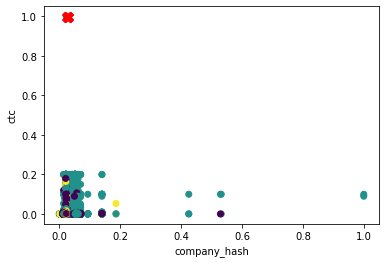

In [91]:
def viz_clusters(kmeans):
    plt.scatter(clusters['job_position'], clusters['ctc'], c=clusters['label'])
    plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], 
                color="red",
                marker="X",
                s=100)
    plt.xlabel('company_hash')
    plt.ylabel('ctc')
    
viz_clusters(kmeans)

In [93]:
clusters['label'].value_counts()

1    112273
0     71765
2     12958
Name: label, dtype: int64

In [95]:
df['label_by_company'].value_counts()

3    91954
2    60644
1    44398
Name: label_by_company, dtype: int64

<AxesSubplot:xlabel='orgyear', ylabel='ctc'>

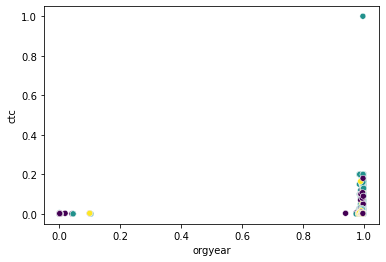

In [100]:

sns.scatterplot(clusters['orgyear'],clusters['ctc'], c=clusters['label'])

<AxesSubplot:xlabel='orgyear', ylabel='ctc'>

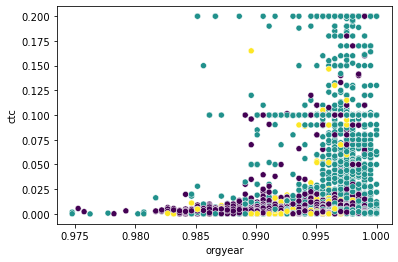

In [111]:
 X  = clusters[(clusters['orgyear'] > 0.97)  & (clusters['ctc'] < 0.9)]

sns.scatterplot(X['orgyear'],X['ctc'], c=X['label'])


<AxesSubplot:xlabel='job_position', ylabel='ctc'>

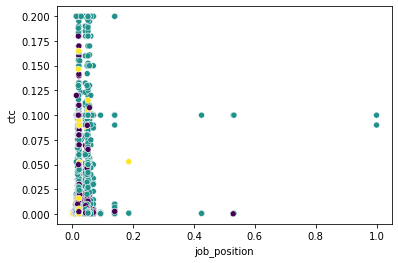

In [113]:
sns.scatterplot(X['job_position'],X['ctc'], c=X['label'])

In [112]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE,mean_ctc_by_company_YOE,label_by_company_yoe,mean_ctc_by_company_job,label_by_company_job,mean_ctc_by_company,label_by_company
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,4,942500.000,1,1085000.000,1,1115666.667,2
1,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014,1070000,Other,2018,4,942500.000,1,1085000.000,2,1115666.667,2
2,atrgxnnt xzaxv,b4dcd1e7ac426014a32ae303e4b527325d482e4d2c4bef...,2014,1000000,Backend Engineer,2018,4,942500.000,1,750000.000,1,1115666.667,2
3,atrgxnnt xzaxv,a309a8c6610af7e9f0a88cfb67f9a0095b0dde63475475...,2019,500000,Backend Engineer,2020,1,500000.000,3,750000.000,2,1115666.667,3
4,atrgxnnt xzaxv,0d2f25432591093f5907a8681d600f869bbe7c2ae39cd7...,2017,600000,Android Engineer,2021,4,942500.000,2,600000.000,3,1115666.667,2


<AxesSubplot:xlabel='ctc_updated_year', ylabel='ctc'>

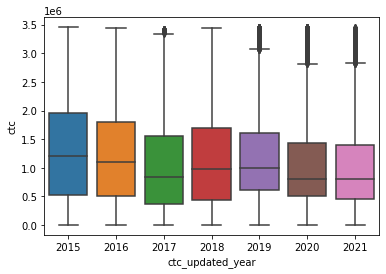

In [121]:
sns.boxplot(x = df['ctc_updated_year'].astype('O'), y = df['ctc'])

In [119]:
# Lets try the IQR Method. 

Q1 = df['ctc'].quantile(0.25)
Q3 = df['ctc'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

df  = df[(df['ctc'] > lower_bound) & (df['ctc'] < upper_bound)]


<AxesSubplot:xlabel='ctc', ylabel='Density'>

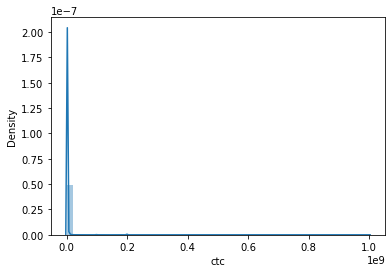

In [118]:
sns.distplot(df['ctc'])

<AxesSubplot:xlabel='ctc', ylabel='Density'>

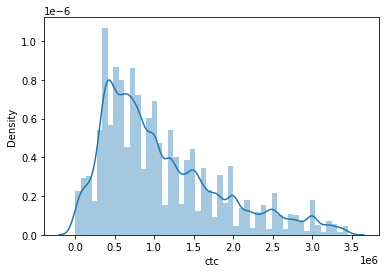

In [120]:
sns.distplot(df['ctc'])

<AxesSubplot:xlabel='ctc'>

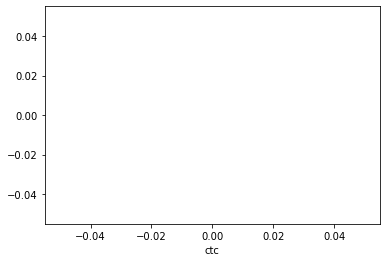

In [122]:
sns.scatterplot(df['ctc'])